# 🌍 Climate Change Modeling for India 🇮🇳
### Author: Garvit Babbar  
This notebook analyzes long-term climate change trends in India, focusing on temperature data. We use time series forecasting (ARIMA) to model and predict future temperature patterns.

---

## 📦 1. Install Required Libraries


In [6]:
!pip install pandas matplotlib seaborn statsmodels openpyxl


---

## 📥 2. Load the Climate Dataset for India

We'll use World Bank's global temperature dataset or a pre-cleaned version with Indian average annual multi-variate data from 2001 onwards.


In [9]:
import pandas as pd
df = pd.read_csv("india_climate_multivariate_2001_2021.csv", index_col="Year")
df.head()

,Temperature,Precipitation,CO2_ppm,Solar_GHI,SeaLevel_mm
Year,,,,,
2001,23.85,990,372.6,4550,54.8
2002,23.79,1002,374.2,4560,57.2
2003,23.91,980,375.7,4555,59.3
2004,24.03,1015,377.5,4570,60.7
2005,24.05,995,379.8,4568,62.1


---

## 📊 3. Visualize All Variables Over Time


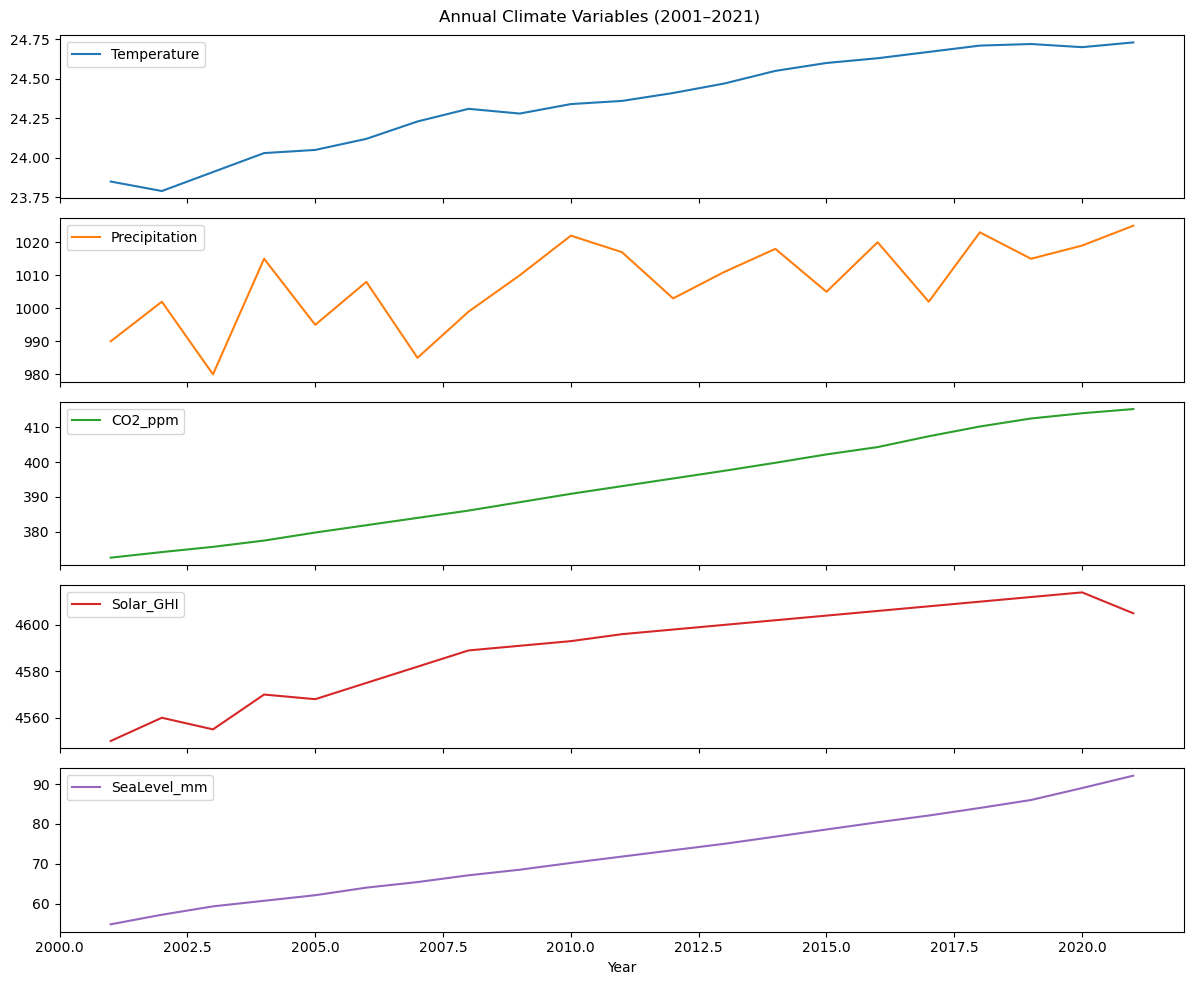

In [11]:
import matplotlib.pyplot as plt
df.plot(subplots=True, figsize=(12,10), title="Annual Climate Variables (2001–2021)")
plt.tight_layout()
plt.show()

## 🔍 4. Correlation Analysis

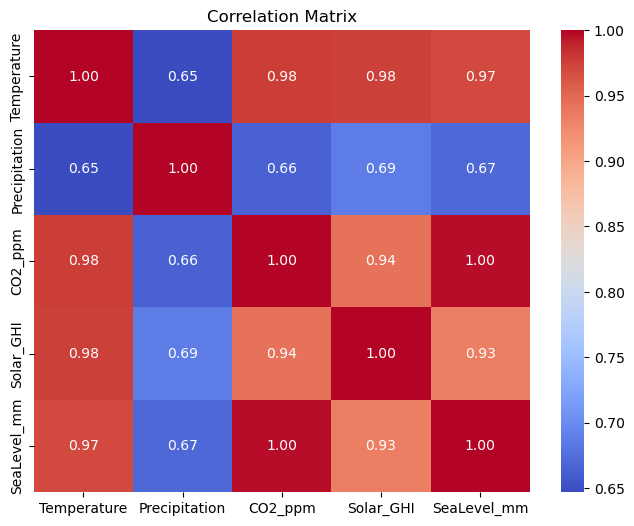

In [13]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

---

## 🔧 5. Fit ARIMAX: Predict Temperature


In [31]:
# Fix: train index to datetime for proper time-aware forecasting
train.index = pd.period_range(start='2001', periods=len(train), freq='Y')
test.index = pd.period_range(start='2017', periods=len(test), freq='Y')

In [33]:
# Assign time-based index to exogenous variables too
exog_train.index = train.index
exog_test.index = test.index

# 1. Set correct DateTimeIndex with yearly frequency
train.index = pd.date_range(start='2001', periods=len(train), freq='YS')  # Start of each year
test.index = pd.date_range(start='2017', periods=len(test), freq='YS')

# 2. Fit the model
model = SARIMAX(train['Temperature'], order=(1,1,1), exog=exog_train)
res = model.fit(disp=False)

# 3. Forecast
forecast = res.predict(start=test.index[0], end=test.index[-1], exog=exog_test)


In [34]:
print(train.index.equals(exog_train.index))  # Should return True
print(test.index.equals(exog_test.index))    # Should return True

True
True


---

## 📉 6. Forecast Temperature (2017–2021) and Evaluate


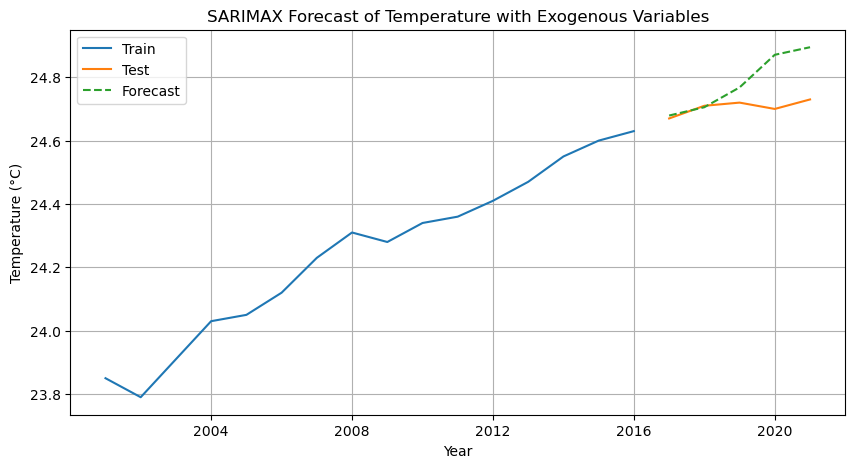

In [38]:
forecast = res.predict(start=test.index[0], end=test.index[-1], exog=exog_test)

plt.figure(figsize=(10,5))
plt.plot(train.index, train['Temperature'], label='Train')
plt.plot(test.index, test['Temperature'], label='Test')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title('SARIMAX Forecast of Temperature with Exogenous Variables')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Actual vs predicted
y_true = test['Temperature']
y_pred = forecast

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

Mean Absolute Error (MAE): 0.079
Root Mean Squared Error (RMSE): 0.108


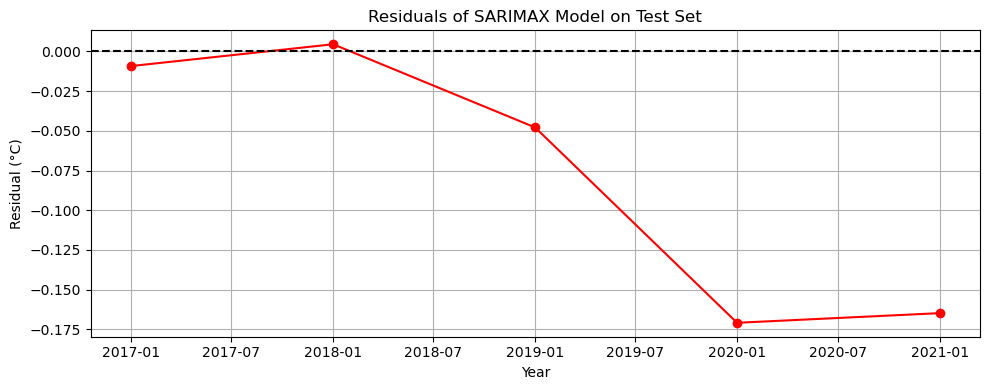

In [53]:
# Calculate residuals on test set
y_true = test['Temperature']
y_pred = res.get_prediction(start=test.index[0], end=test.index[-1], exog=exog_test).predicted_mean
residuals = y_true - y_pred

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(test.index, residuals, marker='o', linestyle='-', color='red')
plt.axhline(0, linestyle='--', color='black')
plt.title("Residuals of SARIMAX Model on Test Set")
plt.xlabel("Year")
plt.ylabel("Residual (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
from sklearn.metrics import r2_score

r2 = r2_score(y_true, y_pred)
print(f"R² Score on Test Set: {r2:.3f}")

R² Score on Test Set: -26.730


In [68]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Merge full dataset
full_df = pd.concat([train, test])

# Define features (X) and target (y)
X = full_df[['Precipitation', 'CO2_ppm', 'Solar_GHI', 'SeaLevel_mm']].values
y = full_df['Temperature'].values

# TimeSeries Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
fold = 1

for train_index, val_index in tscv.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Fit SARIMAX model on training data
    model = SARIMAX(y_train, exog=X_train, order=(1,1,0))
    results = model.fit(disp=False)

    # Forecast on validation set
    y_pred = results.forecast(steps=len(y_val), exog=X_val)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"Fold {fold}: RMSE = {rmse:.3f}")
    fold += 1

Fold 1: RMSE = 0.459
Fold 2: RMSE = 0.031
Fold 3: RMSE = 0.100
Fold 4: RMSE = 0.017
Fold 5: RMSE = 0.077


# Random Forest + TimeSeriesSplit (with RMSE Evaluation)

In [61]:
# Define exogenous variables (used as features)
exog = df[['Precipitation', 'CO2_ppm', 'Solar_GHI', 'SeaLevel_mm']]
X = exog.values
y = df['Temperature'].values

🌲 Random Forest Cross-Validation Results:
Fold 1: RMSE = 0.201
Fold 2: RMSE = 0.101
Fold 3: RMSE = 0.169
Fold 4: RMSE = 0.113
Fold 5: RMSE = 0.051

Average RMSE: 0.127


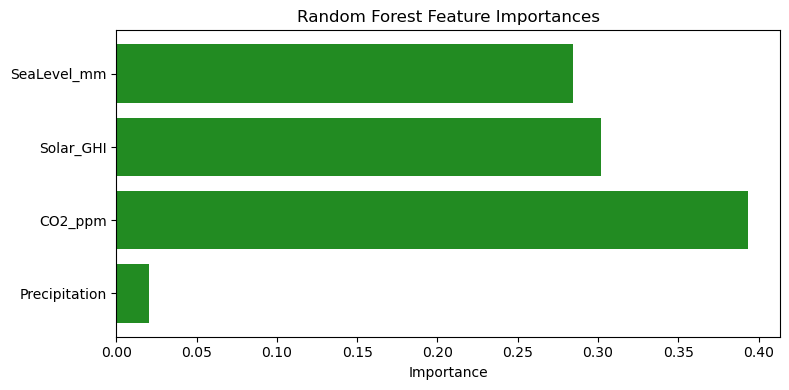

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
X = exog.values  # exogenous features
y = df['Temperature'].values  # target variable

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
rf_rmse_scores = []

print("🌲 Random Forest Cross-Validation Results:")

for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rf_rmse_scores.append(rmse)

    print(f"Fold {fold}: RMSE = {rmse:.3f}")

# Average RMSE
print(f"\nAverage RMSE: {np.mean(rf_rmse_scores):.3f}")

# Plot feature importances from the last fold
feature_names = exog.columns
importances = rf.feature_importances_

plt.figure(figsize=(8,4))
plt.barh(feature_names, importances, color='forestgreen')
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

---

## 🔮 7.Forecast Future: 2022–2026


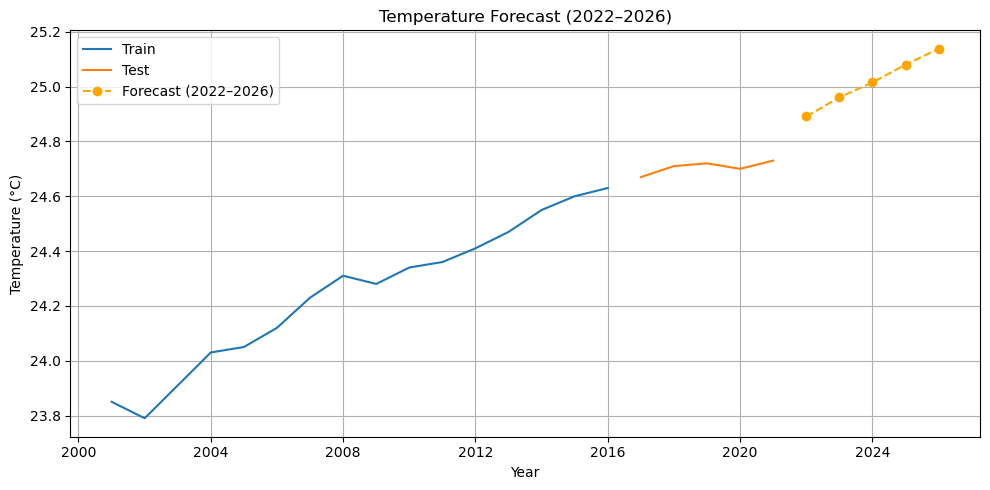

In [50]:
# Step 7a: Create future exog data (5 years)
future_years = pd.date_range(start='2022', periods=5, freq='YS')

future_exog = pd.DataFrame({
    'Precipitation': np.linspace(exog_test['Precipitation'].values[-1], exog_test['Precipitation'].values[-1]+0.5, 5),
    'CO2_ppm': np.linspace(exog_test['CO2_ppm'].values[-1], exog_test['CO2_ppm'].values[-1]+10, 5),
    'Solar_GHI': np.linspace(exog_test['Solar_GHI'].values[-1], exog_test['Solar_GHI'].values[-1]+1, 5),
    'SeaLevel_mm': np.linspace(exog_test['SeaLevel_mm'].values[-1], exog_test['SeaLevel_mm'].values[-1]+10, 5),
}, index=future_years)

# Step 7b: Forecast using get_forecast (auto-handles shape issues)
future_forecast = res.get_forecast(steps=5, exog=future_exog)
forecast_mean = future_forecast.predicted_mean

# Step 7c: Plot everything
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['Temperature'], label='Train')
plt.plot(test.index, test['Temperature'], label='Test')
plt.plot(future_years, forecast_mean, label='Forecast (2022–2026)', linestyle='--', marker='o', color='orange')
plt.title("Temperature Forecast (2022–2026)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Using Random Forest

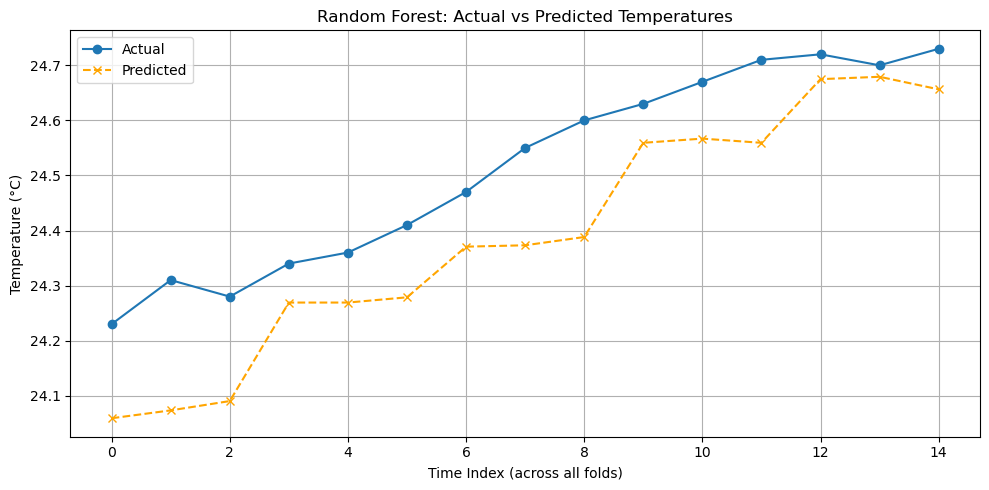

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Define exog and target
X = climate_df[['Precipitation', 'CO2_ppm', 'Solar_GHI', 'SeaLevel_mm']].values
y = climate_df['Temperature'].values

# Initialize model and TSCV
rf = RandomForestRegressor(random_state=42, n_estimators=100)
tscv = TimeSeriesSplit(n_splits=5)

# Collect predictions for all folds
all_true = []
all_pred = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)

    all_true.extend(y_test)
    all_pred.extend(preds)

# Convert to numpy arrays
all_true = np.array(all_true)
all_pred = np.array(all_pred)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(all_true, label='Actual', marker='o')
plt.plot(all_pred, label='Predicted', linestyle='--', marker='x', color='orange')
plt.title('Random Forest: Actual vs Predicted Temperatures')
plt.xlabel('Time Index (across all folds)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

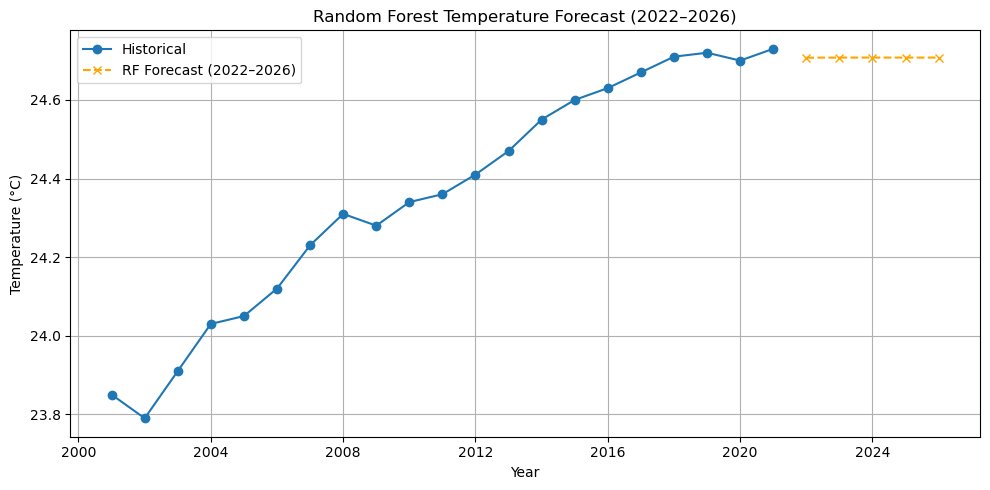

In [75]:
#Re-train Random Forest model on entire historical dataset
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Features and target
X = climate_df[['Precipitation', 'CO2_ppm', 'Solar_GHI', 'SeaLevel_mm']].values
y = climate_df['Temperature'].values

# Fit final model
rf_final = RandomForestRegressor(n_estimators=100, random_state=42)
rf_final.fit(X, y)

# Forecast future temperature using pre-prepared future_exog (2022–2026)
# Make sure future_exog has correct shape and matching columns
future_pred_rf = rf_final.predict(future_exog.values)

# Plot historical + forecasted future temperatures
plt.figure(figsize=(10, 5))

# Plot historical
plt.plot(climate_df.index, climate_df['Temperature'], label='Historical', marker='o')

# Plot forecast
plt.plot(future_exog.index, future_pred_rf, label='RF Forecast (2022–2026)', linestyle='--', marker='x', color='orange')

# Aesthetics
plt.title("Random Forest Temperature Forecast (2022–2026)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 🌪️ 8. Analyze Extreme Climate Conditions in India
✅ Goal:
Identify trends in extreme temperature, rainfall, or sea-level rise. This step doesn't involve prediction but focuses on detecting past extremes and visualizing them.

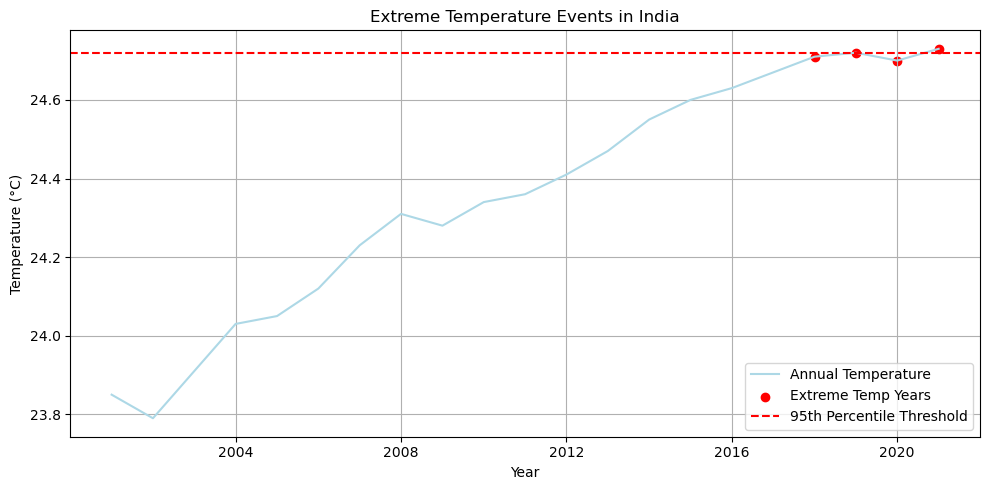

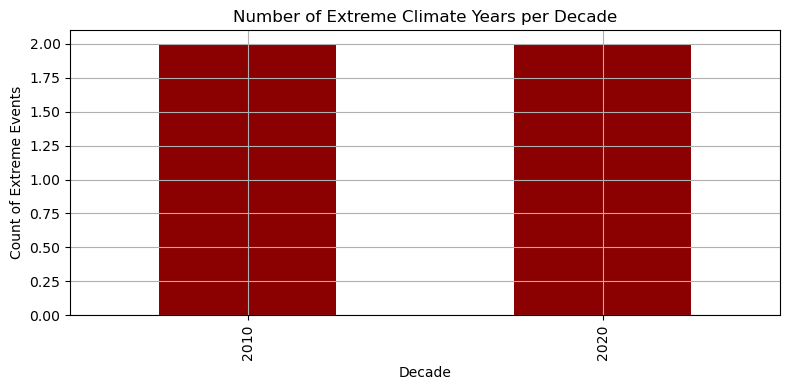

In [52]:
# 📊 8. Analyze Extreme Climate Conditions

# 8a. Define thresholds for "extreme" events
climate_df = pd.concat([train, test])  # Includes full historical data till 2021

extreme_temp_threshold = climate_df['Temperature'].quantile(0.95)  # Top 5% warmest years
extreme_precip_threshold = climate_df['Precipitation'].quantile(0.95)  # Top 5% wettest years
extreme_sea_level_threshold = climate_df['SeaLevel_mm'].quantile(0.95)  # Highest sea levels

# 8b. Extract extreme condition years
extreme_years = climate_df[
    (climate_df['Temperature'] >= extreme_temp_threshold) |
    (climate_df['Precipitation'] >= extreme_precip_threshold) |
    (climate_df['SeaLevel_mm'] >= extreme_sea_level_threshold)
]

# 8c. Plot extreme temperature years
plt.figure(figsize=(10, 5))
plt.plot(climate_df.index, climate_df['Temperature'], label='Annual Temperature', color='lightblue')
plt.scatter(extreme_years.index, extreme_years['Temperature'], color='red', label='Extreme Temp Years')
plt.axhline(extreme_temp_threshold, color='red', linestyle='--', label='95th Percentile Threshold')
plt.title("Extreme Temperature Events in India")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8d. Count of extreme events by decade
extreme_decade_counts = extreme_years.groupby((extreme_years.index.year // 10) * 10).size()
extreme_decade_counts.plot(kind='bar', color='darkred', figsize=(8,4))
plt.title("Number of Extreme Climate Years per Decade")
plt.xlabel("Decade")
plt.ylabel("Count of Extreme Events")
plt.grid(True)
plt.tight_layout()
plt.show()


# 🔶 9. Scenario Analysis: Impact of CO₂ Levels on Temperature (2022–2026)

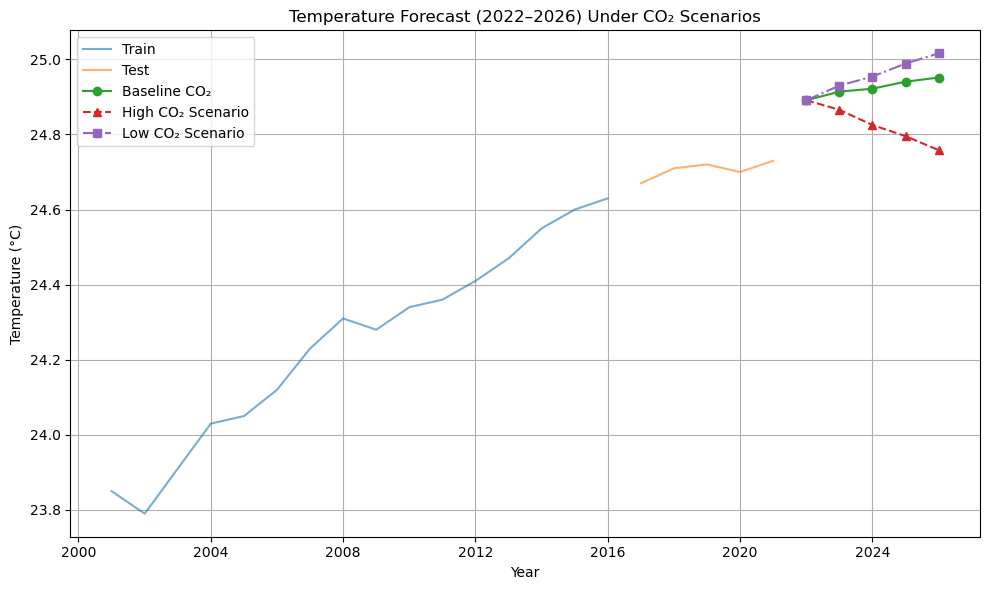

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 📌 Setup years and base values from last available year in exog_test
future_years = pd.date_range(start='2022', periods=5, freq='YS')
base_precip = exog_test['Precipitation'].values[-1]
base_co2 = exog_test['CO2_ppm'].values[-1]
base_solar = exog_test['Solar_GHI'].values[-1]
base_sea = exog_test['SeaLevel_mm'].values[-1]

# 📈 Scenario 1: Baseline (moderate increase)
scenario_baseline = pd.DataFrame({
    'Precipitation': np.linspace(base_precip, base_precip + 0.5, 5),
    'CO2_ppm': np.linspace(base_co2, base_co2 + 10, 5),
    'Solar_GHI': np.linspace(base_solar, base_solar + 0.5, 5),
    'SeaLevel_mm': np.linspace(base_sea, base_sea + 5, 5)
}, index=future_years)

# 📈 Scenario 2: High CO2 increase (business as usual)
scenario_high = pd.DataFrame({
    'Precipitation': np.linspace(base_precip, base_precip + 0.5, 5),
    'CO2_ppm': np.linspace(base_co2, base_co2 + 25, 5),
    'Solar_GHI': np.linspace(base_solar, base_solar + 0.5, 5),
    'SeaLevel_mm': np.linspace(base_sea, base_sea + 5, 5)
}, index=future_years)

# 📈 Scenario 3: Low CO2 (strict climate policy)
scenario_low = pd.DataFrame({
    'Precipitation': np.linspace(base_precip, base_precip + 0.5, 5),
    'CO2_ppm': np.linspace(base_co2, base_co2 + 5, 5),
    'Solar_GHI': np.linspace(base_solar, base_solar + 0.5, 5),
    'SeaLevel_mm': np.linspace(base_sea, base_sea + 5, 5)
}, index=future_years)

# 🔮 Forecast for each scenario using the SARIMAX model
forecast_baseline = res.get_forecast(steps=5, exog=scenario_baseline).predicted_mean
forecast_high = res.get_forecast(steps=5, exog=scenario_high).predicted_mean
forecast_low = res.get_forecast(steps=5, exog=scenario_low).predicted_mean

# 📊 Plot
plt.figure(figsize=(10,6))
plt.plot(train.index, train['Temperature'], label='Train', alpha=0.6)
plt.plot(test.index, test['Temperature'], label='Test', alpha=0.6)
plt.plot(future_years, forecast_baseline, label='Baseline CO₂', marker='o')
plt.plot(future_years, forecast_high, label='High CO₂ Scenario', linestyle='--', marker='^')
plt.plot(future_years, forecast_low, label='Low CO₂ Scenario', linestyle='-.', marker='s')
plt.title("Temperature Forecast (2022–2026) Under CO₂ Scenarios")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Summary Table of Forecasts

In [71]:
scenario_df = pd.DataFrame({
    'Year': future_years.year,
    'Baseline_CO2': forecast_baseline.values,
    'High_CO2': forecast_high.values,
    'Low_CO2': forecast_low.values
})
scenario_df.set_index('Year', inplace=True)
scenario_df

,Baseline_CO2,High_CO2,Low_CO2
Year,,,
2022,24.891009,24.891009,24.891009
2023,24.914043,24.865691,24.930161
2024,24.921916,24.825212,24.954151
2025,24.940588,24.795531,24.988940
2026,24.951568,24.758159,25.016038


# Temperature Projections Under CO₂ Policies

In [81]:
# Prepare training data
X = exog.values  # Your features (precipitation, CO2, solar, sea level)
y = df['Temperature'].values  # Target temperature

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(exog, y)

RandomForestRegressor(random_state=42)

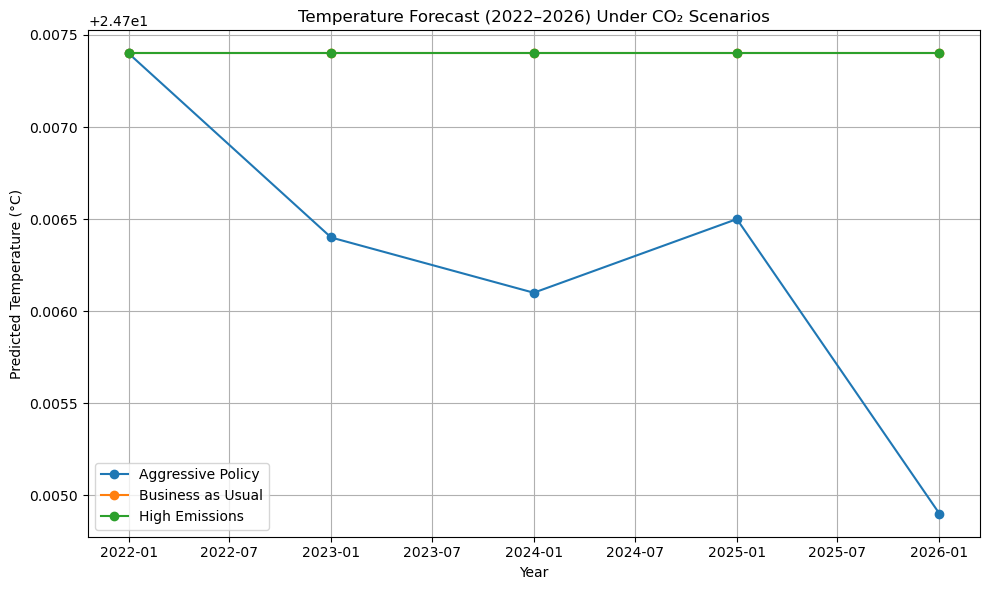

In [96]:
# 📌 Assumptions:
# We fix other variables (Precipitation, Solar_GHI, SeaLevel_mm) at their latest known values
# and vary only CO₂ to simulate different climate policies.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reuse the last values from your exog_test as base for all
last_vals = exog_test.iloc[-1]

future_years = pd.date_range(start='2022', periods=5, freq='YS')

# 🟢 Scenario A: Aggressive CO₂ Reduction
scenario_a = pd.DataFrame({
    'Precipitation': [last_vals['Precipitation']] * 5,
    'CO2_ppm': np.linspace(last_vals['CO2_ppm'], last_vals['CO2_ppm'] - 5, 5),  # reduce CO2
    'Solar_GHI': [last_vals['Solar_GHI']] * 5,
    'SeaLevel_mm': [last_vals['SeaLevel_mm']] * 5
}, index=future_years)

# 🔵 Scenario B: Business as Usual (Slight Increase)
scenario_b = pd.DataFrame({
    'Precipitation': [last_vals['Precipitation']] * 5,
    'CO2_ppm': np.linspace(last_vals['CO2_ppm'], last_vals['CO2_ppm'] + 10, 5),  # increase CO2
    'Solar_GHI': [last_vals['Solar_GHI']] * 5,
    'SeaLevel_mm': [last_vals['SeaLevel_mm']] * 5
}, index=future_years)

# 🔴 Scenario C: High Emissions (Worst Case)
scenario_c = pd.DataFrame({
    'Precipitation': [last_vals['Precipitation']] * 5,
    'CO2_ppm': np.linspace(last_vals['CO2_ppm'], last_vals['CO2_ppm'] + 25, 5),  # sharp rise in CO2
    'Solar_GHI': [last_vals['Solar_GHI']] * 5,
    'SeaLevel_mm': [last_vals['SeaLevel_mm']] * 5
}, index=future_years)

# 🎯 Predict with trained Random Forest model
pred_a = rf_model.predict(scenario_a)
pred_b = rf_model.predict(scenario_b)
pred_c = rf_model.predict(scenario_c)

# 📊 Plotting
plt.figure(figsize=(10, 6))
plt.plot(future_years, pred_a, label='Aggressive Policy', marker='o')
plt.plot(future_years, pred_b, label='Business as Usual', marker='o')
plt.plot(future_years, pred_c, label='High Emissions', marker='o')
plt.title("Temperature Forecast (2022–2026) Under CO₂ Scenarios")
plt.xlabel("Year")
plt.ylabel("Predicted Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()